In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

-----------
Data Loading and Visualisation
---------

In [97]:
KMU2GIB_EVENT_COUNT = 20000
KMU2GSDINT_RATIO = 0.00419
K2PI_RATIO = 33.3387
KMU3_RATIO = 5.4048

In [98]:
matplotlib.rcParams['figure.figsize'] = (9, 6)
# plt.style.use('dark_background')

In [99]:
def read_dir(directory):
    # Initialize an empty list to store the dataframes
    dfs = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            # Read the CSV file into a dataframe
            filepath = os.path.join(directory, filename)
            try:
                df = pd.read_csv(filepath)
            except:
                print(f'Error reading {filepath}')
                continue
            
            # Append the dataframe to the list
            dfs.append(df)

    # Concatenate all dataframes into one
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [100]:
kmu2gib_df = read_dir("kmu2gibdata")
kmu2gsd_df = read_dir("kmu2gsddata")
kmu2gintm_df = read_dir("kmu2gintmdata")
k2pi_df = read_dir("k2pidata")
kmu3_df = read_dir("kmu3data")

Error reading k2pidata/out1.csv
Error reading k2pidata/out17.csv
Error reading k2pidata/out18.csv
Error reading k2pidata/out2.csv
Error reading k2pidata/out21.csv
Error reading k2pidata/out24.csv
Error reading k2pidata/out3.csv
Error reading k2pidata/out32.csv
Error reading k2pidata/out4.csv
Error reading k2pidata/out6.csv
Error reading k2pidata/out9.csv


In [101]:
k2pi_df['CumulativeEventCount'] = k2pi_df['EventCount'].cumsum()
kmu3_df['CumulativeEventCount'] = kmu3_df['EventCount'].cumsum()
kmu2gsd_df['CumulativeEventCount'] = kmu2gsd_df['EventCount'].cumsum()
kmu2gintm_df['CumulativeEventCount'] = kmu2gintm_df['EventCount'].cumsum()
kmu2gib_df['CumulativeEventCount'] = kmu2gib_df['EventCount'].cumsum()

In [102]:
k2pi_df["CumulativeEventCount"].max(), kmu3_df["CumulativeEventCount"].max()

(1490569, 7033119)

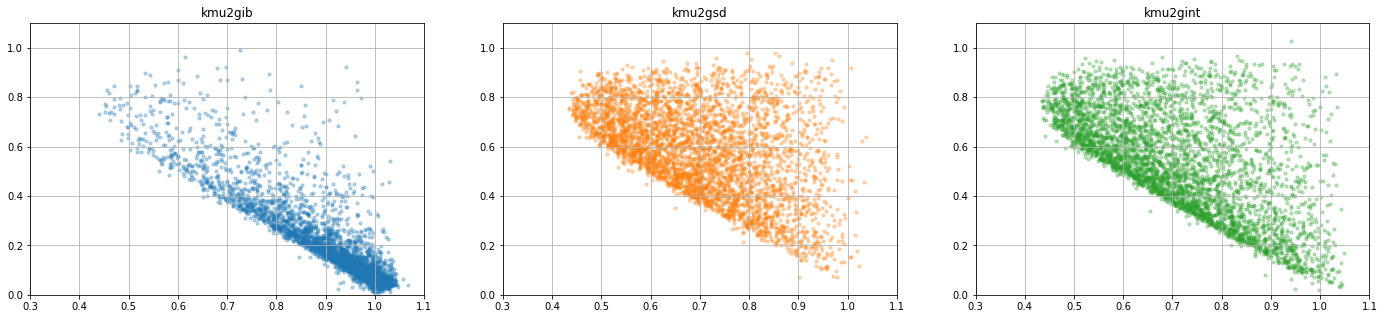

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))
ax[0].scatter(kmu2gib_df["XMu"], kmu2gib_df["XGamma"], s=10, alpha=0.3, c="C0")
ax[0].set_xlim(0.3, 1.1)
ax[0].set_ylim(0, 1.1)
ax[0].grid()
ax[1].scatter(kmu2gsd_df["XMu"], kmu2gsd_df["XGamma"], s=10, alpha=0.3, c="C1")
ax[1].set_xlim(0.3, 1.1)
ax[1].set_ylim(0, 1.1)
ax[1].grid()
ax[2].scatter(kmu2gintm_df["XMu"], kmu2gintm_df["XGamma"], s=10, alpha=0.3, c="C2")
ax[2].set_xlim(0.3, 1.1)
ax[2].set_ylim(0, 1.1)
ax[2].grid()
ax[0].title.set_text('kmu2gib')
ax[1].title.set_text("kmu2gsd")
ax[2].title.set_text("kmu2gint")
plt.show()


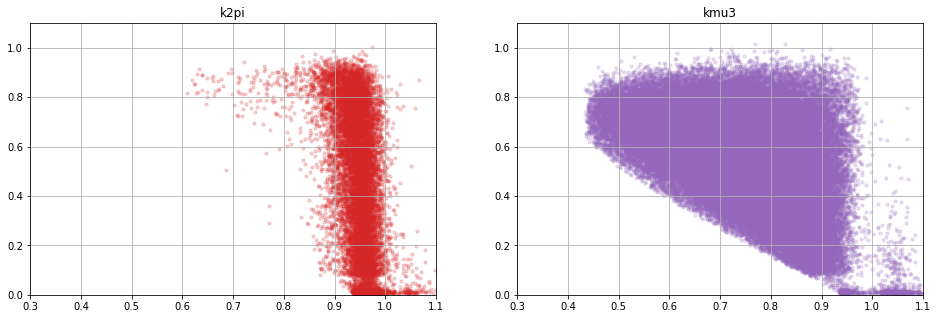

In [104]:
fig2, ax2 = plt.subplots(1, 2, figsize=(16, 5))
ax2[0].scatter(k2pi_df["XMu"], k2pi_df["XGamma"], s=10, alpha=0.2, c="C3")
ax2[0].set_xlim(0.3, 1.1)
ax2[0].set_ylim(0, 1.1)
ax2[0].grid()
ax2[1].scatter(kmu3_df["XMu"], kmu3_df["XGamma"], s=10, alpha=0.2, c="C4")
ax2[1].set_xlim(0.3, 1.1)
ax2[1].set_ylim(0, 1.1)
ax2[1].grid()
ax2[0].title.set_text('k2pi')
ax2[1].title.set_text("kmu3")
plt.show()

In [105]:
kmu2gsd_df_sub = kmu2gsd_df[kmu2gsd_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * (KMU2GSDINT_RATIO/2)]
kmu2gintm_df_sub = kmu2gintm_df[kmu2gintm_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * (KMU2GSDINT_RATIO/2)]
k2pi_df_sub = k2pi_df[k2pi_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * K2PI_RATIO]
kmu3_df_sub = kmu3_df[kmu3_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * KMU3_RATIO]

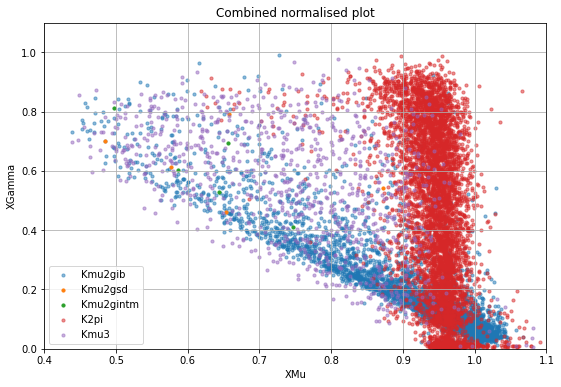

In [106]:
plt.scatter(kmu2gib_df["XMu"], kmu2gib_df["XGamma"], s=10, alpha=0.5, label="Kmu2gib")
plt.scatter(kmu2gsd_df_sub["XMu"], kmu2gsd_df_sub["XGamma"], s=10, alpha=1, label="Kmu2gsd")
plt.scatter(kmu2gintm_df_sub["XMu"], kmu2gintm_df_sub["XGamma"], s=10, alpha=1, label="Kmu2gintm")
plt.scatter(k2pi_df_sub["XMu"], k2pi_df_sub["XGamma"], s=10, alpha=0.5, label="K2pi")
plt.scatter(kmu3_df_sub["XMu"], kmu3_df_sub["XGamma"], s=10, alpha=0.5, label="Kmu3")
plt.xlim(0.4, 1.1)
plt.ylim(0, 1.1)
plt.xlabel("XMu")
plt.ylabel("XGamma")
plt.title("Combined normalised plot")
plt.grid()
plt.legend()
plt.show()

---------
Exploratory Analysis
---------

In [107]:
# Add mode column for classification
# 1 - kmu2gib, 2 - kmu2gsd, 3 - kmu2gintm, 4 - k2pi, 5 - kmu3
kmu2gib_df["Mode"] = 1
kmu2gsd_df_sub["Mode"] = 2
kmu2gintm_df_sub["Mode"] = 3
k2pi_df_sub["Mode"] = 4
kmu3_df_sub["Mode"] = 5

combined_df = pd.concat([kmu2gib_df, kmu2gsd_df_sub, kmu2gintm_df_sub, k2pi_df_sub, kmu3_df_sub], ignore_index=True)
combined_df.head()

/tmp/yuanye/ipykernel_2010345/3614633367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmu2gsd_df_sub["Mode"] = 2
/tmp/yuanye/ipykernel_2010345/3614633367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmu2gintm_df_sub["Mode"] = 3
/tmp/yuanye/ipykernel_2010345/3614633367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,EventCount,GTKMomentumX,GTKMomentumY,GTKMomentumZ,GTKEnergy,GTKGamma,GTKBeta,NLKrCells,NLKrClusters,LKrClusterEnergy,...,MissingMomentumX,MissingMomentumY,MissingMomentumZ,MissingMassSquared,KaonMass,CDAAfterCut,XGamma,XMu,CumulativeEventCount,Mode
0,2,0.086383,0.006344,74.9367,74.9384,151.795,0.999978,2,2,0.636122,...,-0.002676,-0.192919,0.104368,0.001698,0.489843,5.095640,0.137183,0.958610,2,1
1,2,0.087944,0.004353,74.9970,74.9986,151.918,0.999978,2,2,0.598496,...,-0.025490,0.103667,-0.210818,-0.002465,0.498955,5.476340,0.044741,1.019300,4,1
2,17,0.091698,0.004303,73.8888,73.8905,149.673,0.999978,2,2,0.510163,...,-0.001639,0.224760,-0.052429,0.000242,0.493157,0.364728,0.108892,0.953972,21,1
3,13,0.078475,0.003350,73.7343,73.7360,149.360,0.999978,2,2,0.527540,...,-0.216886,-0.021969,-0.080431,0.000528,0.492548,0.759692,0.058449,0.995625,34,1
4,7,0.098726,-0.001611,74.8016,74.8033,151.522,0.999978,2,2,0.617125,...,0.041496,0.167677,-0.091014,0.000166,0.493254,18.501000,0.314814,0.892479,41,1


In [108]:
# Remove unnecessary columns for classification
combined_df = combined_df.drop(columns=["NLKrCells", "NLKrClusters", "NVertices", "NTracks", "GTKMomentumX", "GTKMomentumY", "GTKMomentumZ", "GTKEnergy", "GTKGamma", "GTKBeta", "EventCount", "GTKMomentumX", "GTKMomentumY", "GTKMomentumZ", "MuonMomentumX", "MuonMomentumY", "MuonMomentumZ", "CDAAfterCut", "CumulativeEventCount"])

<AxesSubplot:>

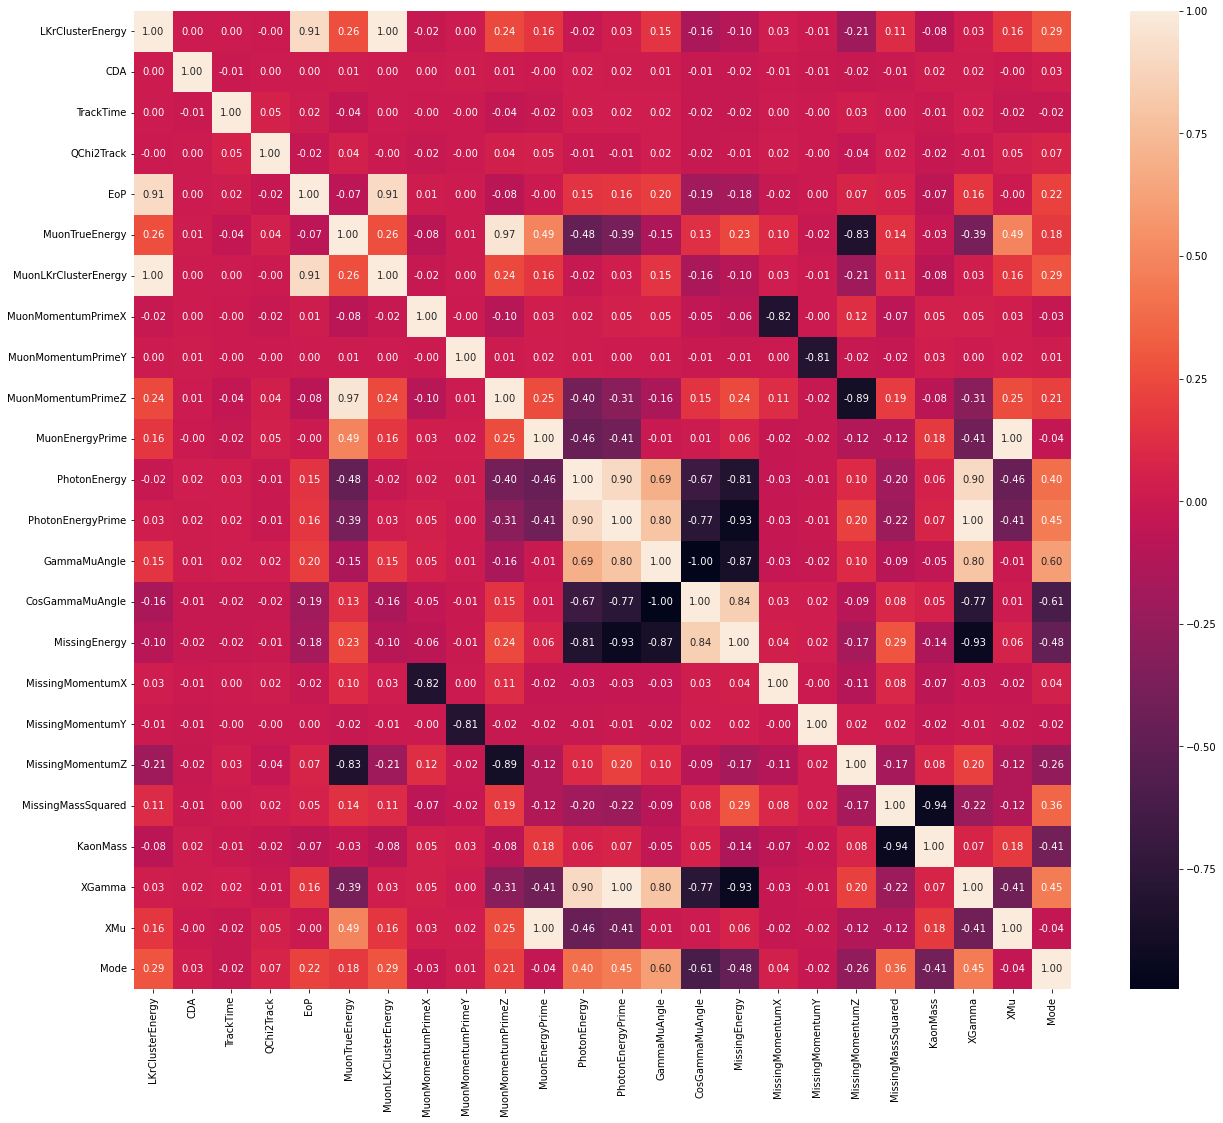

In [109]:
plt.figure(figsize=(21, 18))
sns.heatmap(combined_df.corr(), annot=True, fmt='.2f')

In [110]:
X = combined_df.drop(columns=["Mode"])
y = combined_df["Mode"]

Text(0.5, 1.0, 'KMeans Clustering')

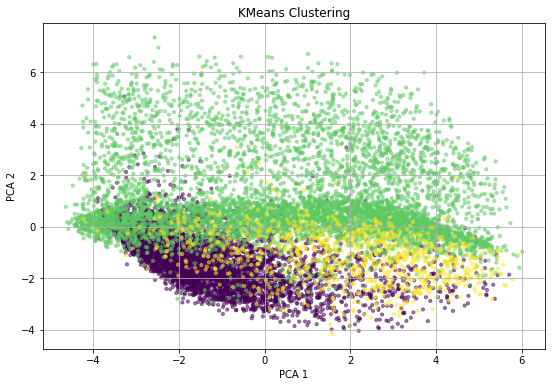

In [111]:
# perform PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=len(X.columns))
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10, alpha=0.5, cmap='viridis')
plt.grid()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clustering")

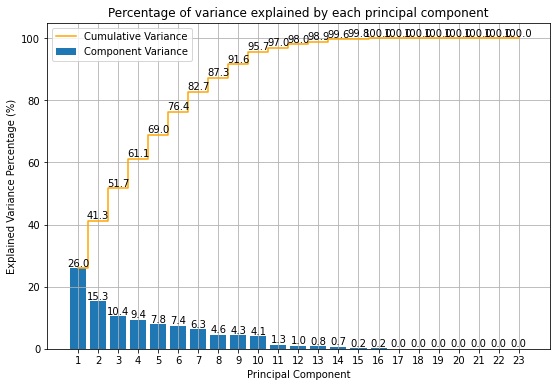

In [112]:
# plotting the principle component variance
plt.bar_label(plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_ * 100, tick_label=range(1, len(pca.explained_variance_ratio_)+1), label="Component Variance"), fmt="%.1f")
# plot the cumulative as a step line
plt.step(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_ * 100), where='mid', color='orange', label="Cumulative Variance")
# assign values on the cumulative line
for i, j in zip(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_ * 100)):
    # the first component and cumulative variance is the same so skip
    if i == 0:
        continue
    plt.text(i, j, f"{j:.1f}", ha='center', va='bottom')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Percentage (%)')
plt.title("Percentage of variance explained by each principal component")
plt.grid()
plt.legend()

PCA in 2D doesnt perform well as there are too many important principal components

----------
Machine Learning
----------

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Decision Tree
---------------

In [114]:
# Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [115]:
y_pred_tree = dtree.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_tree)))

Accuracy: 0.9185228604923799


In [116]:
report = classification_report(y_test, y_pred_tree, target_names=['kmu2gib', 'kmu2gsd', 'kmu2gint', 'k2pi', 'kmu3'])
print(report)

              precision    recall  f1-score   support

     kmu2gib       0.93      0.93      0.93      1342
     kmu2gsd       0.00      0.00      0.00         3
    kmu2gint       0.00      0.00      0.00         2
        k2pi       0.96      0.95      0.95      1804
        kmu3       0.63      0.68      0.65       261

    accuracy                           0.92      3412
   macro avg       0.50      0.51      0.51      3412
weighted avg       0.92      0.92      0.92      3412



/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/scikitlearn/0.24.2/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/scikitlearn/0.24.2/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/scikitlearn/0.24.2/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set 

Random Forest
----------

In [117]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [118]:
y_pred_forest = forest.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_forest)))

Accuracy: 0.9475381008206331


In [119]:
print(classification_report(y_test, y_pred_forest, target_names=['kmu2gib', 'kmu2gsd', 'kmu2gint', 'k2pi', 'kmu3']))

              precision    recall  f1-score   support

     kmu2gib       0.96      0.96      0.96      1342
     kmu2gsd       0.00      0.00      0.00         3
    kmu2gint       0.00      0.00      0.00         2
        k2pi       0.96      0.98      0.97      1804
        kmu3       0.81      0.71      0.76       261

    accuracy                           0.95      3412
   macro avg       0.54      0.53      0.54      3412
weighted avg       0.94      0.95      0.95      3412



/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/scikitlearn/0.24.2/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/scikitlearn/0.24.2/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/scikitlearn/0.24.2/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set 